In [ ]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  #hide any pandas warnings

sns.set(style="whitegrid", color_codes=True)

In [67]:
# Read data
file_name = 'heart_2.csv'
ds = pd.read_csv(file_name)

# Drop rows with thal equal to 0
ds.drop(ds[ds['thal'] == 0].index, axis=0, inplace=True)

In [68]:

# Columns rename
ds.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

# Modifico i valori in modo da identificare con chiarezza le
# feature categoriche
ds['sex'][ds['sex'] == 0] = 'female'
ds['sex'][ds['sex'] == 1] = 'male'

ds['chest_pain_type'][ds['chest_pain_type'] == 0] = 'typical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 1] = 'atypical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 2] = 'non-anginal pain'
ds['chest_pain_type'][ds['chest_pain_type'] == 3] = 'asymptomatic'

ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

ds['rest_ecg'][ds['rest_ecg'] == 0] = 'normal'
ds['rest_ecg'][ds['rest_ecg'] == 1] = 'ST-T wave abnormality'
ds['rest_ecg'][ds['rest_ecg'] == 2] = 'left ventricular hypertrophy'

ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 0] = 'no'
ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 1] = 'yes'

ds['st_slope'][ds['st_slope'] == 0] = 'upsloping'
ds['st_slope'][ds['st_slope'] == 1] = 'flat'
ds['st_slope'][ds['st_slope'] == 2] = 'downsloping'

ds['thalassemia'][ds['thalassemia'] == 1] = 'normal'
ds['thalassemia'][ds['thalassemia'] == 2] = 'fixed defect'
ds['thalassemia'][ds['thalassemia'] == 3] = 'reversable defect'


# Converto i tipi in modo corretto

ds['sex'] = ds['sex'].astype('object')
ds['chest_pain_type'] = ds['chest_pain_type'].astype('object')
ds['fasting_blood_sugar'] = ds['fasting_blood_sugar'].astype('object')
ds['rest_ecg'] = ds['rest_ecg'].astype('object')
ds['exercise_induced_angina'] = ds['exercise_induced_angina'].astype('object')
ds['st_slope'] = ds['st_slope'].astype('object')
ds['thalassemia'] = ds['thalassemia'].astype('object')

In [69]:
# Dataset sample
ds.sample(10)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
462,52,male,asymptomatic,118,186,lower than 120mg/ml,normal,190,no,0.0,flat,0,normal,1
991,60,male,typical angina,117,230,greater than 120mg/ml,ST-T wave abnormality,160,yes,1.4,downsloping,2,reversable defect,0
714,51,male,asymptomatic,125,213,lower than 120mg/ml,normal,125,yes,1.4,downsloping,1,fixed defect,1
55,55,male,typical angina,140,217,lower than 120mg/ml,ST-T wave abnormality,111,yes,5.6,upsloping,0,reversable defect,0
454,65,female,typical angina,150,225,lower than 120mg/ml,normal,114,no,1.0,flat,3,reversable defect,0
676,60,male,typical angina,130,253,lower than 120mg/ml,ST-T wave abnormality,144,yes,1.4,downsloping,1,reversable defect,0
609,55,female,typical angina,180,327,lower than 120mg/ml,left ventricular hypertrophy,117,yes,3.4,flat,0,fixed defect,0
3,61,male,typical angina,148,203,lower than 120mg/ml,ST-T wave abnormality,161,no,0.0,downsloping,1,reversable defect,0
433,37,male,non-anginal pain,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,upsloping,0,fixed defect,1
93,44,male,typical angina,120,169,lower than 120mg/ml,ST-T wave abnormality,144,yes,2.8,upsloping,0,normal,0


In [70]:
# Shape of dataset
print("Rows:", ds.shape[0], "\nFeatures:", ds.shape[1])

Rows: 1018 
Features: 14


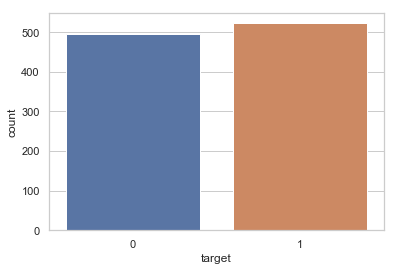

In [71]:
sns.countplot(x=ds['target'])
plt.show()

In [72]:
pd.set_option('display.max_columns', None)
ds.info()
ds.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1018 entries, 0 to 1024
Data columns (total 14 columns):
age                        1018 non-null int64
sex                        1018 non-null object
chest_pain_type            1018 non-null object
resting_blood_pressure     1018 non-null int64
cholesterol                1018 non-null int64
fasting_blood_sugar        1018 non-null object
rest_ecg                   1018 non-null object
max_heart_rate_achieved    1018 non-null int64
exercise_induced_angina    1018 non-null object
st_depression              1018 non-null float64
st_slope                   1018 non-null object
num_major_vessels          1018 non-null int64
thalassemia                1018 non-null object
target                     1018 non-null int64
dtypes: float64(1), int64(6), object(7)
memory usage: 159.3+ KB


,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target
count,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000,1018.000000
mean,54.447937,131.636542,246.253438,149.187623,1.074951,0.759332,0.513752
std,9.101835,17.574327,51.676406,23.006116,1.177640,1.032432,0.500057
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,132.000000,0.000000,0.000000,0.000000
50%,56.000000,130.000000,240.000000,152.000000,0.800000,0.000000,1.000000
75%,61.000000,140.000000,275.750000,166.000000,1.800000,1.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000,1.000000


In [73]:
print("There are missing values?", ds.isnull().values.any())

There are missing values? False


In [74]:
# Dummy features
ds = pd.get_dummies(ds, drop_first=True)

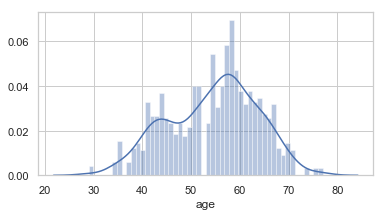

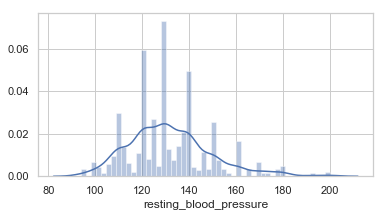

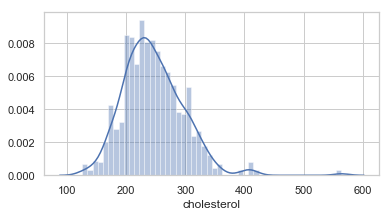

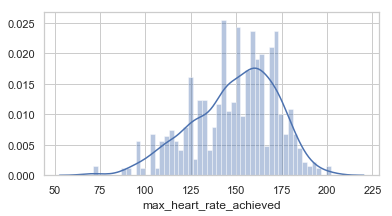

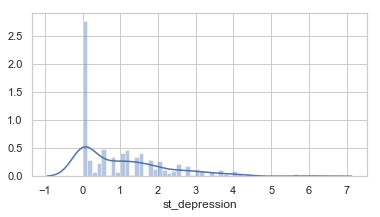

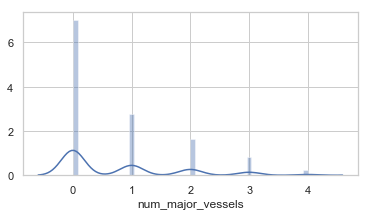

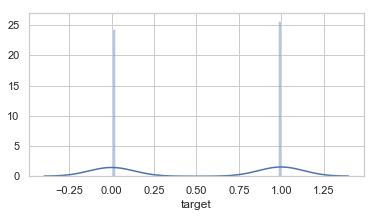

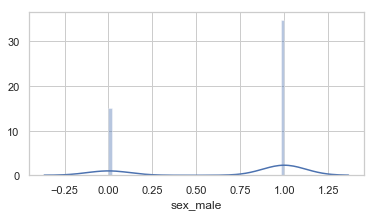

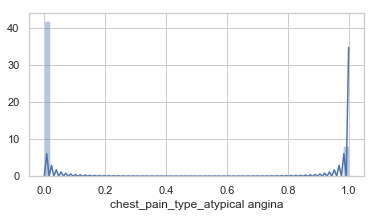

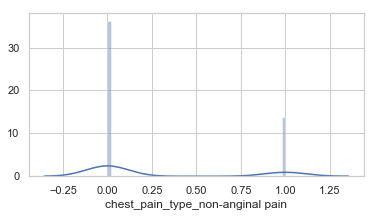

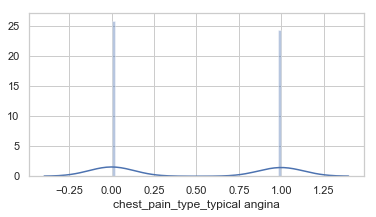

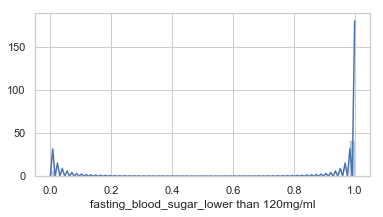

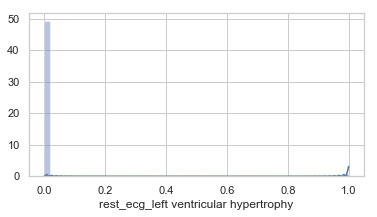

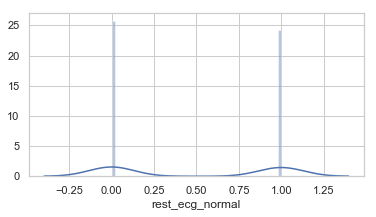

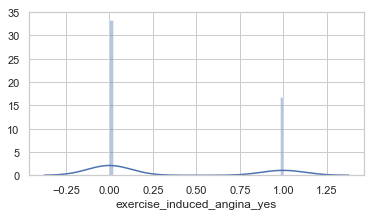

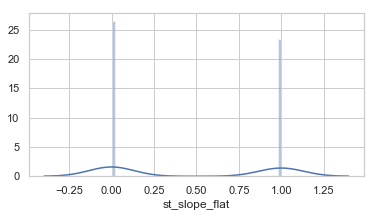

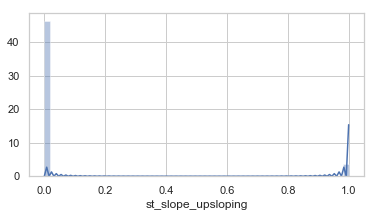

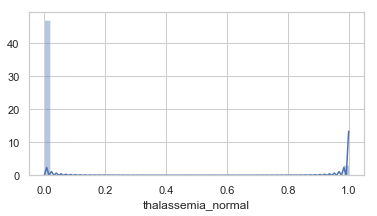

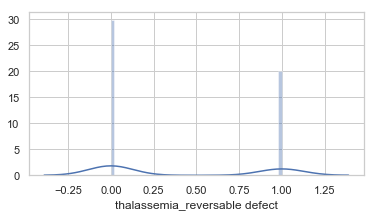

In [75]:
# Analisi sui dati

for c in ds.columns:
    plt.figure(figsize=(6, 3))
    sns.distplot(ds[c], hist=True, bins=50)
    plt.show()


In [76]:
# Split data in dataset and values to predict
X = ds.drop(['target'], axis=1) # X -> data
Y = ds['target'] # Y -> values to predict

In [77]:
#Uso RFC per estrarre le features più importanti
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state = 50)

model.fit(X, Y)
feature_importance = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['RFC']).sort_values('RFC', ascending=False)
model = None
feature_importance.head(14)

,RFC
num_major_vessels,0.155625
st_depression,0.113720
chest_pain_type_typical angina,0.109544
age,0.093028
max_heart_rate_achieved,0.085290
cholesterol,0.075917
exercise_induced_angina_yes,0.068256
resting_blood_pressure,0.062240
thalassemia_reversable defect,0.057721
st_slope_flat,0.033851


In [ ]:
# Normalizzo i dati
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
columns_names = X.columns
# Fit your data on the scaler object
X_scaled = X
X_scaled = scaler.fit_transform(X)
#X = pd.DataFrame(X, columns=columns_names)

In [ ]:
# Split train set and test set (train: 80% test: 20%)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 50)
print("Train set:", np.round(X_train.shape[0]/X.shape[0]*100), "%")
print("Test set:", np.round(X_test.shape[0]/X.shape[0]*100), "%")

In [ ]:
# First attempt
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(random_state = 50)
model = model.fit(X_train, Y_train)
predict = model.predict(X_test)
accuracy = accuracy_score(Y_test, predict)
accuracy = np.round(accuracy * 100, 3)


print("The accuracy score on the testing set:", accuracy,"%")
print("Hyperparameters values:\n", model.get_params())
model = None

from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(random_state = 50)
#model = model.fit(X, Y_train)
accuracy = cross_val_score(model, X, Y, cv = 10, scoring = 'accuracy')
accuracy = np.round(accuracy * 100, 3)

model = None

plt.plot(accuracy, 'b', label="Training Acc")
plt.ylabel('Accuracy score')
plt.show()
print("Accuracy CV:", np.mean(accuracy))

In [ ]:
# Hyperparameters tuning



In [ ]:
from sklearn.model_selection import validation_curve

def do_validation_curve(classifier, x, y, param_name, param_range):
    train_scores, test_scores = validation_curve(
                                    classifier,
                                    X=x, y=y, 
                                    param_name=param_name, 
                                    param_range=param_range,
                                    cv = 3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 5))
    plt.title("Validation Curve with RFC")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 1
    plt.plot(param_range, train_scores_mean,'.-', label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, '.-', label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [ ]:
# Definisco le liste di iperparametri
# n_estimators max_depth min_samples_split min_samples_leaf max_features

max_features = list(range(1,X_scaled.shape[1]))
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 300, 500, 750]
min_samples_leaf = [1, 2, 4, 8]
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bootstrap = [False, True]

In [ ]:
# Tuning n_estimators
do_validation_curve(RandomForestClassifier(), X_train, Y_train, 'n_estimators', n_estimators)

In [ ]:
# Tuning max_features
do_validation_curve(RandomForestClassifier(), X_train, Y_train, 'max_features', max_features)

In [ ]:
# Tuning min_samples_leaf
do_validation_curve(RandomForestClassifier(), X_train, Y_train, 'min_samples_leaf', min_samples_leaf)

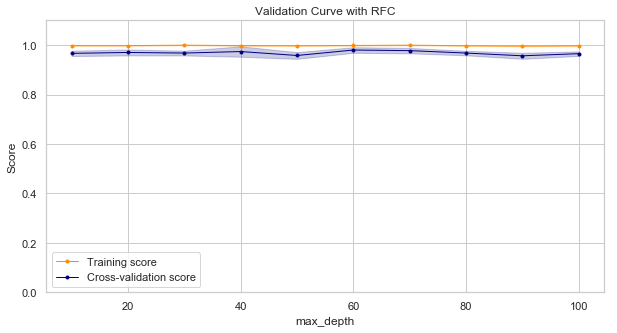

In [90]:
# Tuning max_depth
do_validation_curve(RandomForestClassifier(), X_train, Y_train, 'max_depth', max_depth)

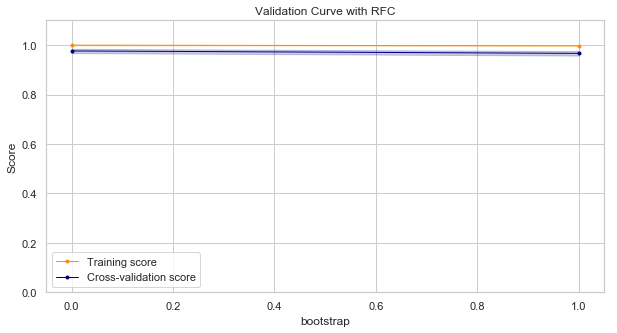

In [91]:
# Tuning bootstrap
do_validation_curve(RandomForestClassifier(), X_train, Y_train, 'bootstrap', bootstrap)

In [2]:
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=40, criterion='gini', random_state = 50)
#model = model.fit(X_train, Y_train)
accuracy = cross_val_score(model, X_train, Y_train, cv = 10, scoring = 'accuracy')
accuracy = np.round(accuracy * 100, 3)

model = None

plt.plot(accuracy, 'b', label="Training Acc")
plt.ylabel('Accuracy score')
plt.show()

NameError: name 'RandomForestClassifier' is not defined

In [93]:
model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=40, criterion='gini', random_state = 50, bootstrap=True)
model = model.fit(X_train, Y_train)
predict = model.predict(X_test)
accuracy = accuracy_score(Y_test, predict)
accuracy = np.round(accuracy * 100, 3)
model = None

print("The accuracy score on the testing set : ", accuracy,"%")

The accuracy score on the testing set :  100.0 %
